# PSTAT 135 Group 22: Final Report

## Introduction:


## Research Questions
- How does socioeconomic background (education, income, religion, etc ) affect voter turnout?
    - How does property (household, land) ownership affect voter turnouts or patterns?
    - How does education level relate to voter alignment or patterns?
    - How would age and gender relate to voter alignment or patterns?

# Import Libraries

In [153]:
import pyspark as spark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession.builder \
        .appName("Model") \
        .config("spark.sql.debug.maxToStringFields", 1000) \
        .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/03/21 03:18:12 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/03/21 03:18:12 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/03/21 03:18:12 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/03/21 03:18:12 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


# Import state data

In [3]:
gcs_path = 'gs://pstat135-voter-file/VM2Uniform'

nv =  spark.read.parquet(gcs_path + "/" + "VM2Uniform--NV--2021-06-13")
fl = spark.read.parquet(gcs_path + "/" + "VM2Uniform--FL--2021-05-19")
mi =  spark.read.parquet(gcs_path + "/" + "VM2Uniform--MI--2021-01-30")
az =  spark.read.parquet(gcs_path + "/" + "VM2Uniform--AZ--2021-05-20")

## EDA

### Property Ownership and Voter Turnout

In [180]:
land_cols = ["General_2020", "Voters_Age", "Voters_Gender","County", "Voters_Active",
                    "Voters_VotingPerformanceEvenYearGeneral", "ElectionReturns_G18CountyTurnoutRepublicans",
                   "ElectionReturns_G18CountyTurnoutIndependentsAllOthers", 
                   "ElectionReturns_G18CountyTurnoutDemocrats",
                   "ElectionReturns_P18CountyTurnoutAllRegisteredVoters",
                   "ElectionReturns_G16CountyTurnoutRepublicans",
                   "ElectionReturns_G16CountyTurnoutIndependentsAllOthers", 
                   "ElectionReturns_G16CountyTurnoutDemocrats",
                   "ElectionReturns_P16CountyTurnoutAllRegisteredVoters",
                   "Residence_Addresses_Property_LandSq_Footage",
                   "Residence_Addresses_Property_HomeSq_Footage",
                    "CommercialDataLL_Gun_Owner",
                    "CommercialDataLL_Interest_in_Religious_Inspirational_In_Household",
                    "Parties_Description"
                    
                   ]
mi_pd = mi.select(*land_cols).sample(True, 0.005, 123).toPandas()

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

mi_pd = mi.sample(10000, random_state=123)

mi_pd["State"] = "MI"

all_pd = mi_pd

all_pd['ElectionReturns_G18CountyTurnoutRepublicans'] = pd.to_numeric(all_pd['ElectionReturns_G18CountyTurnoutRepublicans'].str.replace(r'%', ''))
all_pd['ElectionReturns_G18CountyTurnoutDemocrats'] = pd.to_numeric(all_pd['ElectionReturns_G18CountyTurnoutDemocrats'].str.replace(r'%', ''))
all_pd['ElectionReturns_G16CountyTurnoutRepublicans'] = pd.to_numeric(all_pd['ElectionReturns_G16CountyTurnoutRepublicans'].str.replace(r'%', ''))
all_pd['ElectionReturns_G16CountyTurnoutDemocrats'] = pd.to_numeric(all_pd['ElectionReturns_G16CountyTurnoutDemocrats'].str.replace(r'%', ''))
all_pd["Voters_Age"] = pd.to_numeric(all_pd["Voters_Age"])
all_pd["Residence_Addresses_Property_LandSq_Footage"] = pd.to_numeric(all_pd["Residence_Addresses_Property_LandSq_Footage"])

TypeError: sample() got an unexpected keyword argument 'random_state'

The first idea we explored was the effect property ownership has on turnout. To do this, we selected the Residence_Addresses_Property_LandSq_Footage variable to see how it varies by party.

In [ ]:
land_plot = sns.boxplot(data=all_pd, x="Residence_Addresses_Property_LandSq_Footage", y="State", hue="Parties_Description")
land_plot.set(title="Land Sq. Ft. by Party")
land_plot.set_xlim(0, 150000)
land_plot = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

land_plot

This initial plot is telling us that Republicans tend to have more land in the State of Michigan. Now let's see how voter turnout differs between parties. We are interested in the presidential elections, so we are looking at voter turnout from 2016.

In [ ]:
turnout_2016 = all_pd[["ElectionReturns_G16CountyTurnoutDemocrats", "ElectionReturns_G16CountyTurnoutRepublicans", "State"]]
turnout_2016 = pd.melt(turnout_2016, id_vars="State", value_vars=["ElectionReturns_G16CountyTurnoutDemocrats", "ElectionReturns_G16CountyTurnoutRepublicans"])

turnout_2016_plot = sns.boxplot(data=turnout_2016, x="value", y="State", hue="variable")
turnout_2016_plot.set(title="Voter turnout at 2016 General Election", xlabel="Percent Turnout")
turnout_2016_plot.set_xlim(25,100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [179]:
mi_party_tot = mi.groupBy("Parties_Description").count().sort("Parties_Description")

mi_vote_party = mi.groupBy("Parties_Description", "General_2020").count().sort("Parties_Description")

mi_dem_tot = mi_party_tot.filter(mi_party_tot.Parties_Description == "Democratic").head()[1]
mi_np_tot = mi_party_tot.filter(mi_party_tot.Parties_Description == "Non-Partisan").head()[1]
mi_rep_tot = mi_party_tot.filter(mi_party_tot.Parties_Description == "Republican").head()[1]

mi_vote_party = mi_vote_party.withColumn("Total_Voted_General_2020", mi_vote_party["count"])
mi_vote_party = mi_vote_party.withColumn("Party_Total", F.when(mi_vote_party.Parties_Description == "Democratic",
                                                            mi_dem_tot)
                                                        .when(mi_vote_party.Parties_Description == "Non-Partisan",
                                                            mi_np_tot)
                                                        .when(mi_vote_party.Parties_Description == "Republican",
                                                            mi_rep_tot))

mi_vote_party = mi_vote_party.withColumn("Percent_Voted", F.round(mi_vote_party.Total_Voted_General_2020 / mi_vote_party.Party_Total, 3))
mi_vote_party = mi_vote_party.withColumn("State", F.lit("MI"))
mi_vote_party = mi_vote_party.drop("count")

mi_vote_party = mi_vote_party.filter(mi_vote_party.General_2020 == "Y").drop("General_2020")

KeyboardInterrupt: 

In [ ]:
mi_vote_party.show()

In this swing state that is Michigan, we see about a 15% difference in the median turnout in 2018 between Democrats and Republicans. We also see Non-Partisans having the lowest percent voted at 55%. There seems to be some sort of relationship between land, party and whether or not someone voted.

### Florida EDA

In [159]:
# first pull out columns of interest
interest_cols = ["General_2020",
                 "CommercialData_Education",
                 "Voters_Age", "Voters_Gender",
                 "Residence_Addresses_Property_LandSq_Footage",
                 "Parties_Description", 
                 "CommercialData_EstimatedHHIncomeAmount"                           
]

df_sub=fl.select("General_2020",
                 "CommercialData_Education",
                 "Voters_Age", "Voters_Gender",
                 "Residence_Addresses_Property_LandSq_Footage",
                 "Parties_Description", 
                 "CommercialData_EstimatedHHIncomeAmount")

df_sub.printSchema()

root
 |-- General_2020: string (nullable = true)
 |-- CommercialData_Education: string (nullable = true)
 |-- Voters_Age: string (nullable = true)
 |-- Voters_Gender: string (nullable = true)
 |-- Residence_Addresses_Property_LandSq_Footage: string (nullable = true)
 |-- Parties_Description: string (nullable = true)
 |-- CommercialData_EstimatedHHIncomeAmount: string (nullable = true)



#### Sample
For visualization of the data, we will need to take a sample of the data to be able to process these plots. Summaries will be done with the entire dataset to ensure the plots are what is intended.

In [160]:
# randomly take a sample of the data frame and convert to pandas
fl_pd = fl.select(*interest_cols).sample(True, 0.01, 123).toPandas()

In [162]:
# now take a 10000 subset of the pandaDF
fl_pd = fl_pd.sample(10000, random_state=123)

fl_pd["State"] = "FL"

fl_pd.head()

,General_2020,CommercialData_Education,Voters_Age,Voters_Gender,Residence_Addresses_Property_LandSq_Footage,Parties_Description,CommercialData_EstimatedHHIncomeAmount,State
138895,None,None,62,F,None,Non-Partisan,$30220,FL
82444,Y,None,54,M,0043000,Democratic,$53299,FL
61288,Y,Grad Degree - Extremely Likely,43,F,None,Democratic,$72000,FL
137977,Y,None,55,F,0013000,Registered Independent,$69916,FL
41335,Y,None,65,M,0014000,Republican,$87318,FL


#### Age and Party

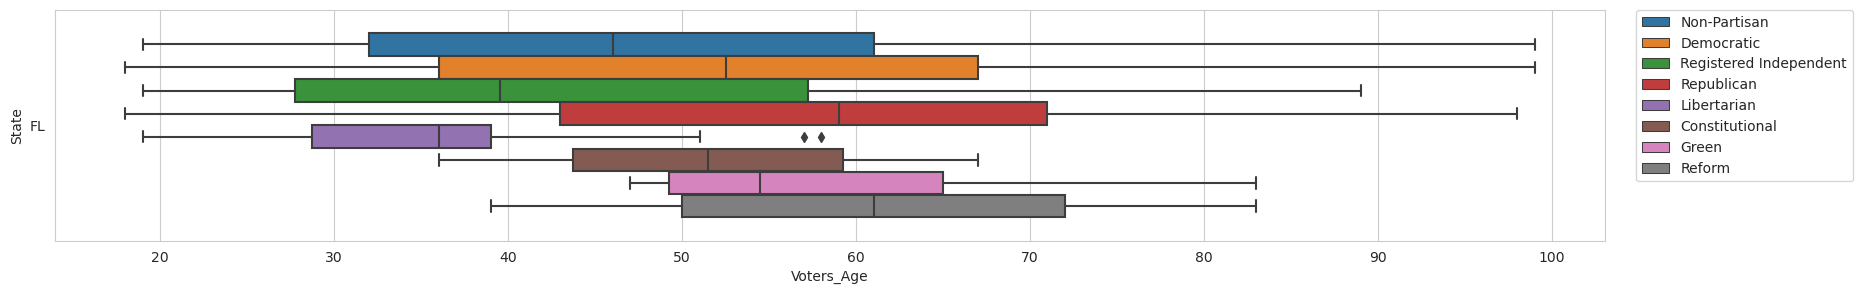

In [163]:
fl_pd['Voters_Age']=pd.to_numeric(fl_pd['Voters_Age'])

ageplot_fl = sns.boxplot(data=fl_pd, x="Voters_Age", y="State",hue="Parties_Description")
ageplot_fl = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ageplot_fl

In [165]:
ageFL = fl.select("Voters_Age",'Parties_Description')
ageFL.groupBy('Parties_Description').agg(F.mean('Voters_Age'), F.count('Voters_Age').alias('Voters_in_Party')).show(10)

+--------------------+------------------+---------------+
| Parties_Description|   avg(Voters_Age)|Voters_in_Party|
+--------------------+------------------+---------------+
|          Republican| 55.78978141797492|        4994235|
|Registered Indepe...| 45.94540307883206|         180523|
|               Other| 39.66997026759167|           1009|
|         Libertarian|40.406567493665804|          39863|
|               Green|39.804321404456445|           7405|
|              Reform| 50.80409556313993|           1465|
|      Constitutional|47.140307907627715|           2858|
|          Democratic|51.874933047463514|        5186510|
|           Socialist| 31.86215334420881|           1226|
|        Non-Partisan| 47.31178927220779|        3741851|
+--------------------+------------------+---------------+



### Arizona EDA

In [166]:
selected_interest = [ "General_2020", "General_2016","General_2018", "PresidentialPrimary_2020","PresidentialPrimary_2016",
                 "Voters_Age", "Voters_Gender", "County", "CountyEthnic_Description", "Voters_Active", "CommercialData_EstimatedHHIncomeAmount",
                   "Voters_VotingPerformanceEvenYearGeneral", 
                   "ElectionReturns_G18CountyTurnoutRepublicans",
                   "ElectionReturns_G18CountyTurnoutIndependentsAllOthers", 
                   "ElectionReturns_G18CountyTurnoutDemocrats",
                   "ElectionReturns_P18CountyTurnoutAllRegisteredVoters",
                   "ElectionReturns_G16CountyTurnoutRepublicans",
                   "ElectionReturns_G16CountyTurnoutIndependentsAllOthers", 
                   "ElectionReturns_G16CountyTurnoutDemocrats",
                   "ElectionReturns_P16CountyTurnoutAllRegisteredVoters",
                   "Residence_Addresses_Property_LandSq_Footage",
                   "Residence_Addresses_Property_HomeSq_Footage",
                   "Parties_Description", 
                   "VoterParties_Change_Changed_Party",
                   "CommercialData_EstimatedHHIncome",
                   "CommercialData_AreaMedianEducationYears",
                   "CommercialDataLL_Household_Primary_Language",
                 "CommercialDataLL_Business_Owner",
                     "CommercialData_EstimatedAreaMedianHHIncome"
]

In [167]:
az_pd = az.select(*selected_interest).sample(True, 0.05, 123).toPandas()
az_pd = az_pd.sample(50000, random_state=123)
az_pd["State"] = "AZ"

In [169]:
az_pd['ElectionReturns_G18CountyTurnoutRepublicans'] = pd.to_numeric(az_pd['ElectionReturns_G18CountyTurnoutRepublicans'].str.replace(r'%', ''))
az_pd['ElectionReturns_G18CountyTurnoutDemocrats'] = pd.to_numeric(az_pd['ElectionReturns_G18CountyTurnoutDemocrats'].str.replace(r'%', ''))
az_pd['ElectionReturns_G16CountyTurnoutRepublicans'] = pd.to_numeric(az_pd['ElectionReturns_G16CountyTurnoutRepublicans'].str.replace(r'%', ''))
az_pd['ElectionReturns_G16CountyTurnoutDemocrats'] = pd.to_numeric(az_pd['ElectionReturns_G16CountyTurnoutDemocrats'].str.replace(r'%', ''))

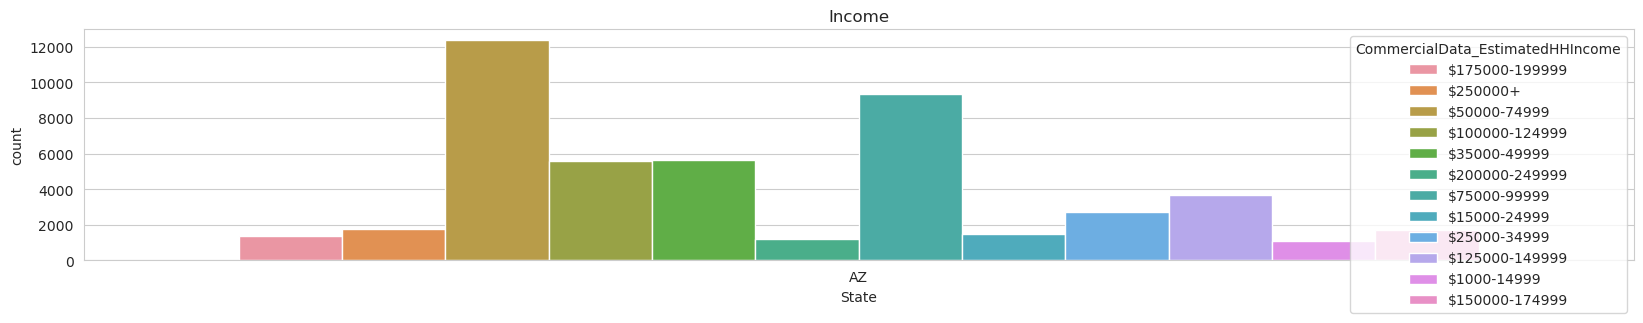

In [170]:
income_chart_az = sns.countplot(data=az_pd, x="State",
                             hue="CommercialData_EstimatedHHIncome").set(title="Income")

From our sample, we can see that most voters turned out to be those whose income falls in the category of 'middle-class' This makes sense since the majority of adults in American make up the middle-class in terms of income.

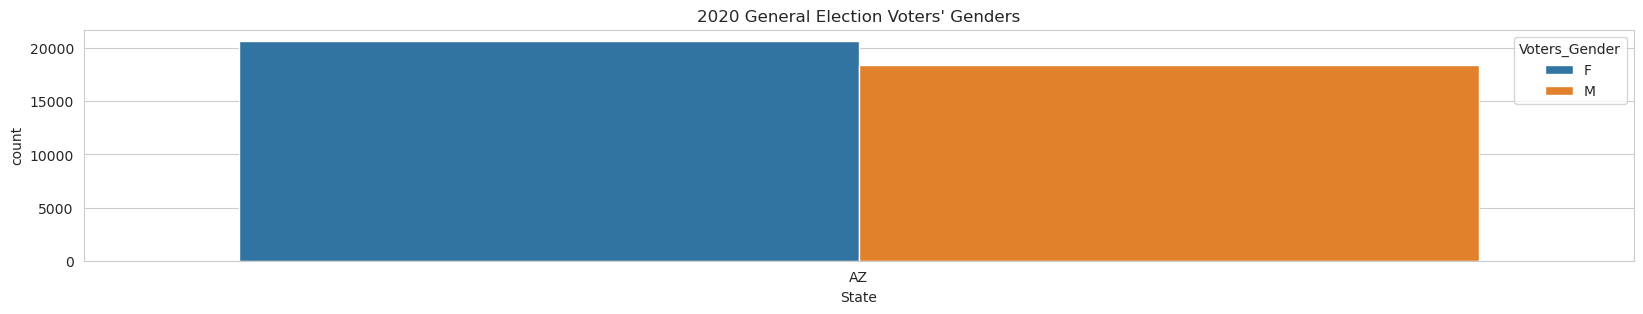

In [173]:
az_voted2020 = az_pd[az_pd["General_2020"] == "Y"]
gender_chart_az = sns.countplot(data=az_voted2020, x="State",
                             hue="Voters_Gender").set(title="2020 General Election Voters' Genders")

In our sample, we see that females were voting more than males in Arizona in the 2020 General Election.

### Nevada EDA

In [ ]:
target_cols = ['Voters_Age',
               'Voters_Gender',
               'Parties_Description',
               'General_2020',
               'Ethnic_Description',
               'CommercialData_Education',
               'CommercialData_DwellingType',
               'CommercialData_AreaMedianHousingValue',
               'CommercialData_AreaMedianEducationYears',
              'CommercialData_EstimatedHHIncomeAmount'
              ]

nv_df = nv.select(*target_cols)

In [39]:
nv_pd = nv_df.toPandas()

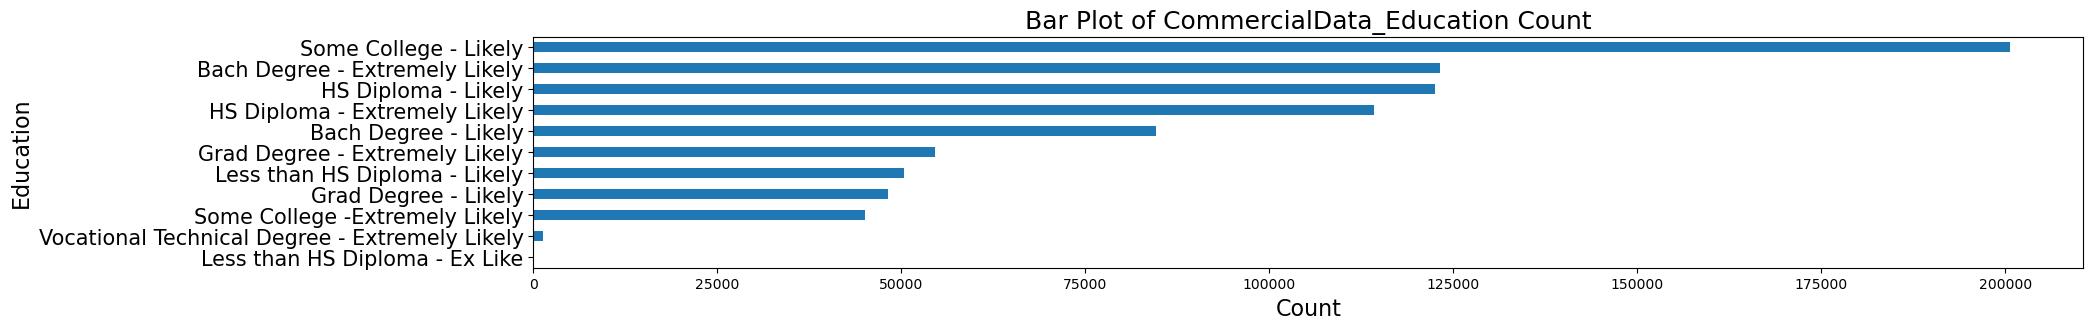

In [89]:
edu_plot = nv_pd['CommercialData_Education'].value_counts().sort_values(ascending=True)

# create a boxplot of the value counts
edu_plot = edu_plot.plot.barh()
edu_plot.set_yticklabels(edu_plot.get_yticklabels(), fontsize=15)
edu_plot.set_xlabel('Count', fontsize=16)
edu_plot.set_ylabel('Education', fontsize=16)
edu_plot.set_title('Bar Plot of CommercialData_Education Count', fontsize=18)
plt.show()

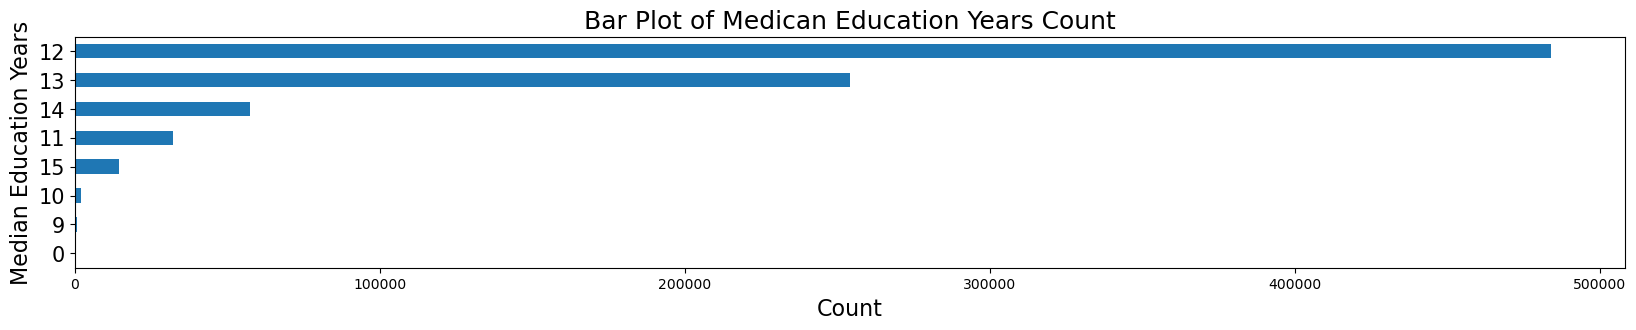

In [105]:
edu_yrs = nv_pd['CommercialData_AreaMedianEducationYears'].value_counts().sort_values(ascending=True)

# create a boxplot of the value counts
edu_yrs = edu_yrs.plot.barh()
edu_yrs.set_yticklabels(edu_yrs.get_yticklabels(), fontsize=15)
edu_yrs.set_xlabel('Count', fontsize=16)
edu_yrs.set_ylabel('Median Education Years', fontsize=16)
edu_yrs.set_title('Bar Plot of Medican Education Years Count', fontsize=18)
plt.show()

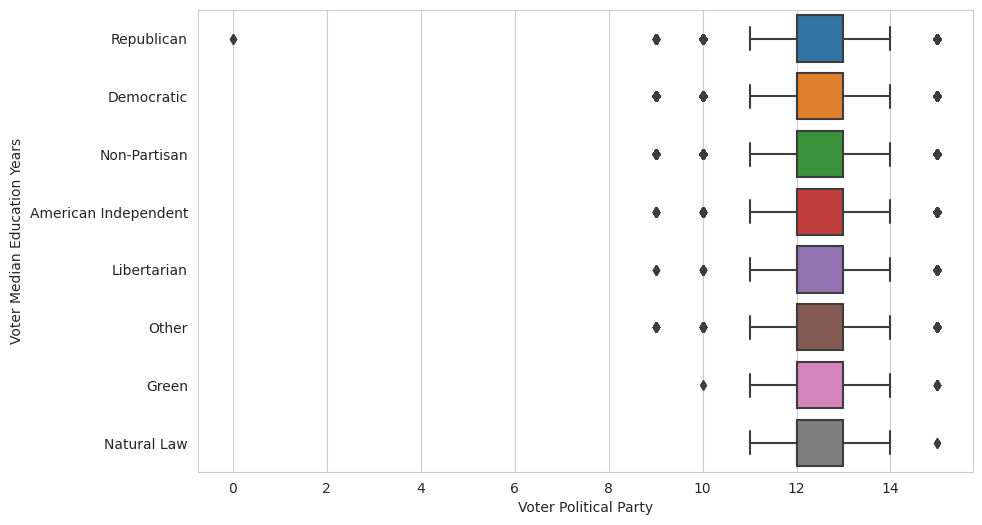

In [145]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(10,6))

# education
sns.boxplot(x='CommercialData_AreaMedianEducationYears', y='Parties_Description', data=nv_pd)

ax.set_xlabel('Voter Political Party')
ax.set_ylabel('Voter Median Education Years')

plt.show()


## Modeling

After some exploratory analysis in these 4 swing states, we decided to use `Voters_Age`, `Voters_Gender`, `Ethnic_Description`, `CommercialData_Education`, `CommercialData_DwellingType`, `CommercialData_AreaMedianHousingValue`, `CommercialData_AreaMedianEducationYears`, and `CommercialData_EstimatedHHIncomeAmount` in order to predict `General_2020`. 

We will use a Logistic Regression model for each state separately then intrepret the variables to see if their are any similarities or differences in voter behaviour in swing states. With this we hope to develop a model that can predict whther or not someone will vote so that certain people or groups can be targetted.

### Data Preparation

In [ ]:
target_cols = ['Voters_Age',
               'Voters_Gender',
               'Parties_Description',
               'General_2020',
               'Ethnic_Description',
               'CommercialData_Education',
               'CommercialData_DwellingType',
               'CommercialData_AreaMedianHousingValue',
               'CommercialData_AreaMedianEducationYears',
              'CommercialData_EstimatedHHIncomeAmount'
              ]

nv_df = nv.select(*target_cols)
fl_df = fl.select(*target_cols)
mi_df = mi.select(*target_cols)
az_df = az.select(*target_cols)

In [5]:
# Define processing function for cleaning
def process_df(df):
    # Create a list of the columns to update
    columns_to_update = ["CommercialData_AreaMedianHousingValue", "CommercialData_EstimatedHHIncomeAmount"]

    # Loop through each column and update the value
    for column in columns_to_update:
        df = df.withColumn(
            column, 
            regexp_replace(col(column), "\\$", "")
        )

    # Cast the following columns to IntegerType
    columns_to_cast = ["Voters_Age",
                       "CommercialData_AreaMedianEducationYears",
                       "CommercialData_AreaMedianHousingValue",
                       "CommercialData_EstimatedHHIncomeAmount"
                      ]

    for col_name in columns_to_cast:
        df = df.withColumn(
            col_name, 
            df[col_name].cast(IntegerType())
        )

    # Create a new column called "label" based on the value of "General_2020"
    df = df.withColumn("label", 
                             when(df.General_2020 == "Y", 1).otherwise(0)
                            )

    # Remove the "General_2020" column and any rows with missing values
    df = df.drop("General_2020").dropna()
    
    return df

In [6]:
nv_df = process_df(nv_df)

nv_df.printSchema()

root
 |-- Voters_Age: integer (nullable = true)
 |-- Voters_Gender: string (nullable = true)
 |-- Parties_Description: string (nullable = true)
 |-- Ethnic_Description: string (nullable = true)
 |-- CommercialData_Education: string (nullable = true)
 |-- CommercialData_DwellingType: string (nullable = true)
 |-- CommercialData_AreaMedianHousingValue: integer (nullable = true)
 |-- CommercialData_AreaMedianEducationYears: integer (nullable = true)
 |-- CommercialData_EstimatedHHIncomeAmount: integer (nullable = true)
 |-- label: integer (nullable = false)



In [7]:
fl_df = process_df(fl_df)

fl_df.printSchema()

root
 |-- Voters_Age: integer (nullable = true)
 |-- Voters_Gender: string (nullable = true)
 |-- Parties_Description: string (nullable = true)
 |-- Ethnic_Description: string (nullable = true)
 |-- CommercialData_Education: string (nullable = true)
 |-- CommercialData_DwellingType: string (nullable = true)
 |-- CommercialData_AreaMedianHousingValue: integer (nullable = true)
 |-- CommercialData_AreaMedianEducationYears: integer (nullable = true)
 |-- CommercialData_EstimatedHHIncomeAmount: integer (nullable = true)
 |-- label: integer (nullable = false)



In [8]:
mi_df = process_df(mi_df)

mi_df.printSchema()

root
 |-- Voters_Age: integer (nullable = true)
 |-- Voters_Gender: string (nullable = true)
 |-- Parties_Description: string (nullable = true)
 |-- Ethnic_Description: string (nullable = true)
 |-- CommercialData_Education: string (nullable = true)
 |-- CommercialData_DwellingType: string (nullable = true)
 |-- CommercialData_AreaMedianHousingValue: integer (nullable = true)
 |-- CommercialData_AreaMedianEducationYears: integer (nullable = true)
 |-- CommercialData_EstimatedHHIncomeAmount: integer (nullable = true)
 |-- label: integer (nullable = false)



In [9]:
az_df = process_df(az_df)

az_df.printSchema()

root
 |-- Voters_Age: integer (nullable = true)
 |-- Voters_Gender: string (nullable = true)
 |-- Parties_Description: string (nullable = true)
 |-- Ethnic_Description: string (nullable = true)
 |-- CommercialData_Education: string (nullable = true)
 |-- CommercialData_DwellingType: string (nullable = true)
 |-- CommercialData_AreaMedianHousingValue: integer (nullable = true)
 |-- CommercialData_AreaMedianEducationYears: integer (nullable = true)
 |-- CommercialData_EstimatedHHIncomeAmount: integer (nullable = true)
 |-- label: integer (nullable = false)



### Split Train/Testing Data 

In [10]:
# Nevada
nv_train_df, nv_test_df = nv_df.randomSplit([0.7, 0.3], seed=43)

# Florida
fl_train_df, fl_test_df = fl_df.randomSplit([0.7, 0.3], seed=43)

# Michigan
mi_train_df, mi_test_df = mi_df.randomSplit([0.7, 0.3], seed=43)

# Arizona
az_train_df, az_test_df = az_df.randomSplit([0.7, 0.3], seed=43)

### Set up pipeline stages

In [11]:
# Import necessary libraries
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# Define string indexer for categorical features
categorical_cols = ['Voters_Gender',
                    'Parties_Description',
                    'Ethnic_Description', 
                    'CommercialData_DwellingType', 
                    'CommercialData_Education'
                   ]

In [12]:
# Pipeline Stage: StringIndexer

# Import necessary libraries
from pyspark.ml.feature import StringIndexer

# Define string indexer for categorical features
categorical_cols = ['Voters_Gender',
                    'Parties_Description',
                    'Ethnic_Description', 
                    'CommercialData_DwellingType', 
                    'CommercialData_Education'
                   ]

indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="skip") for col in categorical_cols]

In [13]:
# Pipeline Stage: OneHotEncoder

# Define one-hot encoder for categorical features
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_vec") for col in categorical_cols]

In [174]:
# Pipeline Stage: Assembler

# Define assembler for all features
assembler = VectorAssembler(inputCols=["Voters_Age",
                                       "CommercialData_AreaMedianHousingValue",
                                       "CommercialData_AreaMedianEducationYears",
                                       "CommercialData_EstimatedHHIncomeAmount"] 
                            + [col+"_vec" for col in categorical_cols], outputCol="features")

### Define Logistic Regression Model & Pipeline

In [15]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
# Define logistic regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Define the pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])

In [16]:
nv_pipeline_model = pipeline.fit(nv_train_df)
nv_train_predictions = nv_pipeline_model.transform(nv_train_df)
nv_test_predictions = nv_pipeline_model.transform(nv_test_df)

23/03/21 03:20:00 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/03/21 03:20:00 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [17]:
fl_pipeline_model = pipeline.fit(fl_train_df)
fl_train_predictions = fl_pipeline_model.transform(fl_train_df)
fl_test_predictions = fl_pipeline_model.transform(fl_test_df)

In [18]:
mi_pipeline_model = pipeline.fit(mi_train_df)
mi_train_predictions = mi_pipeline_model.transform(mi_train_df)
mi_test_predictions = mi_pipeline_model.transform(mi_test_df)

In [19]:
az_pipeline_model = pipeline.fit(az_train_df)
az_train_predictions = az_pipeline_model.transform(az_train_df)
az_test_predictions = az_pipeline_model.transform(az_test_df)

## Interpreting Our Model

In [20]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate the performance of the model
evaluator = BinaryClassificationEvaluator(labelCol="label")

In [21]:
nv_auc_train = evaluator.evaluate(nv_train_predictions)
nv_auc_test = evaluator.evaluate(nv_test_predictions)

# Print the AUC score
print("Training AUC score: {:.2f}%".format(nv_auc_train * 100))
print("Test AUC score: {:.2f}%".format(nv_auc_test * 100))

Training AUC score: 72.26%
Test AUC score: 72.38%


In [22]:
fl_auc_train = evaluator.evaluate(fl_train_predictions)
fl_auc_test = evaluator.evaluate(fl_test_predictions)

# Print the AUC score
print("Training AUC score: {:.2f}%".format(fl_auc_train * 100))
print("Test AUC score: {:.2f}%".format(fl_auc_test * 100))

Training AUC score: 70.32%
Test AUC score: 70.32%


In [23]:
mi_auc_train = evaluator.evaluate(mi_train_predictions)
mi_auc_test = evaluator.evaluate(mi_test_predictions)

# Print the AUC score
print("Training AUC score: {:.2f}%".format(mi_auc_train * 100))
print("Test AUC score: {:.2f}%".format(mi_auc_test * 100))

Training AUC score: 72.46%
Test AUC score: 72.39%


In [24]:
az_auc_train = evaluator.evaluate(az_train_predictions)
az_auc_test = evaluator.evaluate(az_test_predictions)

# Print the AUC score
print("Training AUC score: {:.2f}%".format(az_auc_train * 100))
print("Test AUC score: {:.2f}%".format(az_auc_test * 100))

Training AUC score: 73.76%
Test AUC score: 73.54%


In [27]:
# names of columns used to make feature vector, and then stored in pandaDF
featureCols = pd.DataFrame(nv_train_predictions.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
  nv_train_predictions.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

featureCols = featureCols.set_index('idx')

In [29]:
# Retrieve the logistic regression model from the pipeline
lr_model = nv_pipeline_model.stages[-1]

nv_coefsArray = np.abs(np.array(lr_model.coefficients))  # convert to np.array
nv_coefsDF = pd.DataFrame(nv_coefsArray, columns=['coefs'])  # to pandas

nv_coefsDF = nv_coefsDF.merge(featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
nv_coefsDF.sort_values('coefs', inplace=True)  # Sort them
nv_coefsDF.head()

,coefs,name
1,0.000001,CommercialData_AreaMedianHousingValue
3,0.000002,CommercialData_EstimatedHHIncomeAmount
0,0.024626,Voters_Age
69,0.032187,Ethnic_Description_vec_Luxembourgian
4,0.123826,Voters_Gender_vec_F


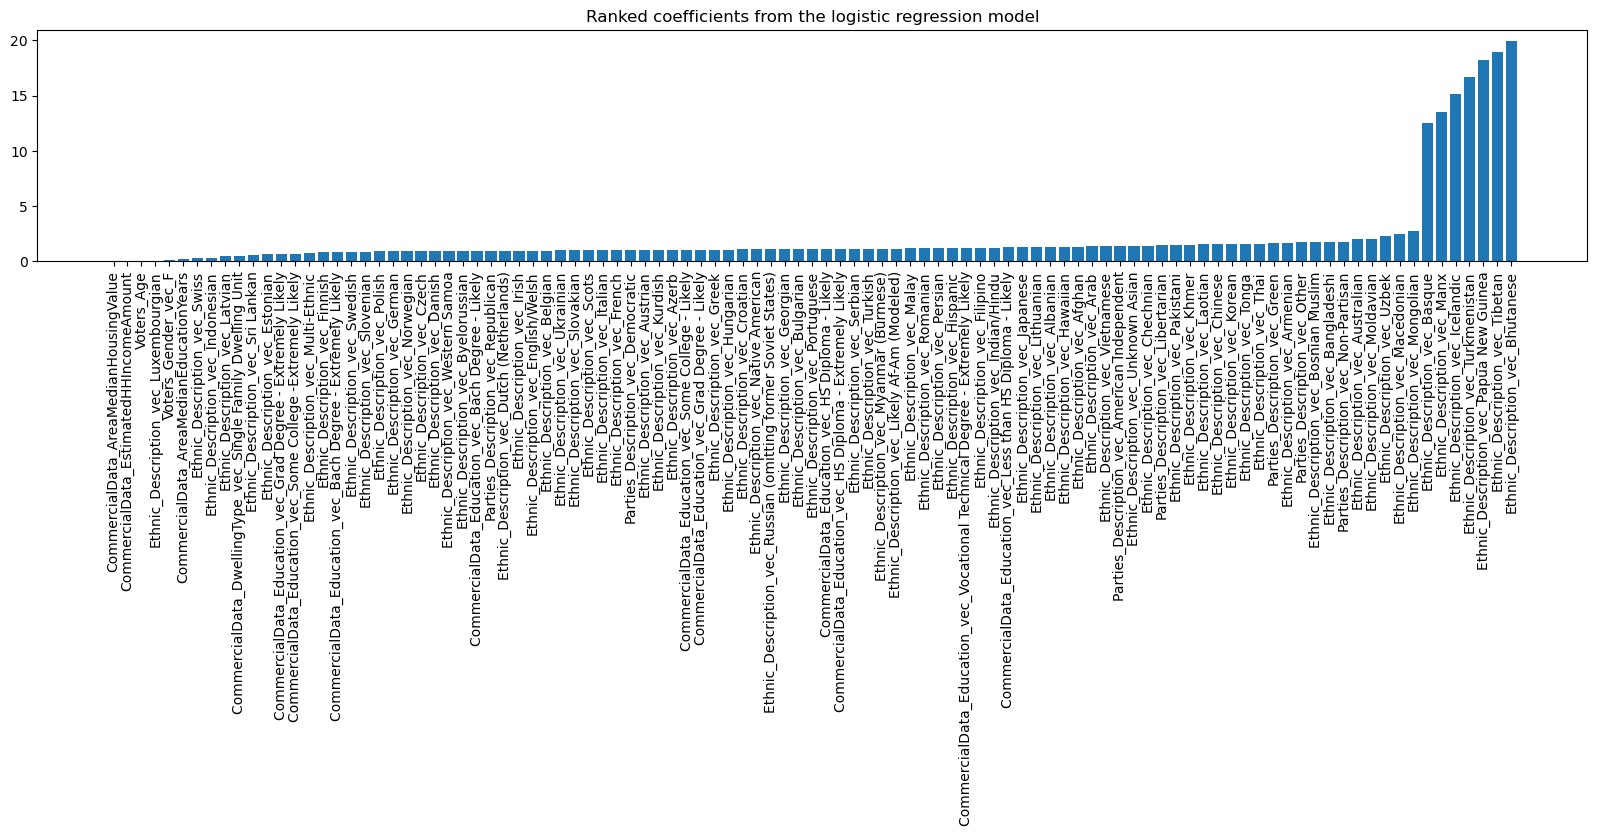

In [30]:
plt.rcParams["figure.figsize"] = (20,3)

plt.xticks(rotation=90)
plt.bar(nv_coefsDF.name, nv_coefsDF.coefs)
plt.title('Ranked coefficients from the logistic regression model')
plt.show()

In [32]:
# Retrieve the logistic regression model from the pipeline
lr_model = fl_pipeline_model.stages[-1]

fl_coefsArray = np.abs(np.array(lr_model.coefficients))  # coflert to np.array
fl_coefsDF = pd.DataFrame(fl_coefsArray, columns=['coefs'])  # to pandas

fl_coefsDF = fl_coefsDF.merge(featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
fl_coefsDF.sort_values('coefs', inplace=True)  # Sort them
fl_coefsDF.head()

,coefs,name
1,6.431543e-07,CommercialData_AreaMedianHousingValue
3,3.437078e-06,CommercialData_EstimatedHHIncomeAmount
0,2.659961e-02,Voters_Age
84,6.806558e-02,Ethnic_Description_vec_Bhutanese
2,1.070027e-01,CommercialData_AreaMedianEducationYears


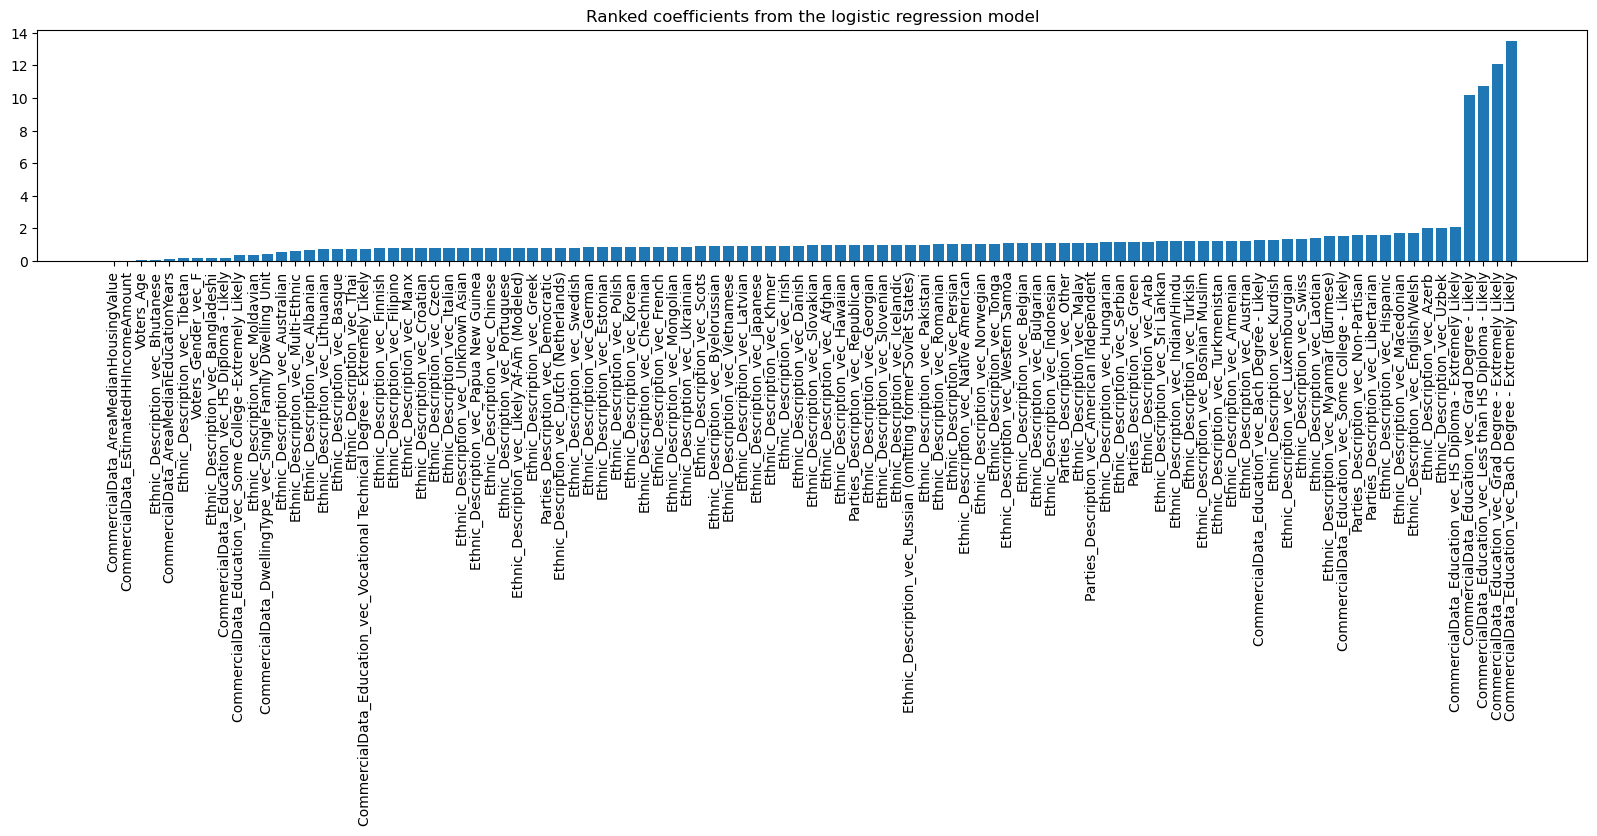

In [33]:
plt.rcParams["figure.figsize"] = (20,3)

plt.xticks(rotation=90)
plt.bar(fl_coefsDF.name, fl_coefsDF.coefs)
plt.title('Ranked coefficients from the logistic regression model')
plt.show()

In [34]:
# Retrieve the logistic regression model from the pipeline
lr_model = mi_pipeline_model.stages[-1]

mi_coefsArray = np.abs(np.array(lr_model.coefficients))  # comiert to np.array
mi_coefsDF = pd.DataFrame(mi_coefsArray, columns=['coefs'])  # to pandas

mi_coefsDF = mi_coefsDF.merge(featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
mi_coefsDF.sort_values('coefs', inplace=True)  # Sort them
mi_coefsDF.head()

,coefs,name
1,0.000002,CommercialData_AreaMedianHousingValue
3,0.000005,CommercialData_EstimatedHHIncomeAmount
0,0.022326,Voters_Age
2,0.133747,CommercialData_AreaMedianEducationYears
4,0.188895,Voters_Gender_vec_F


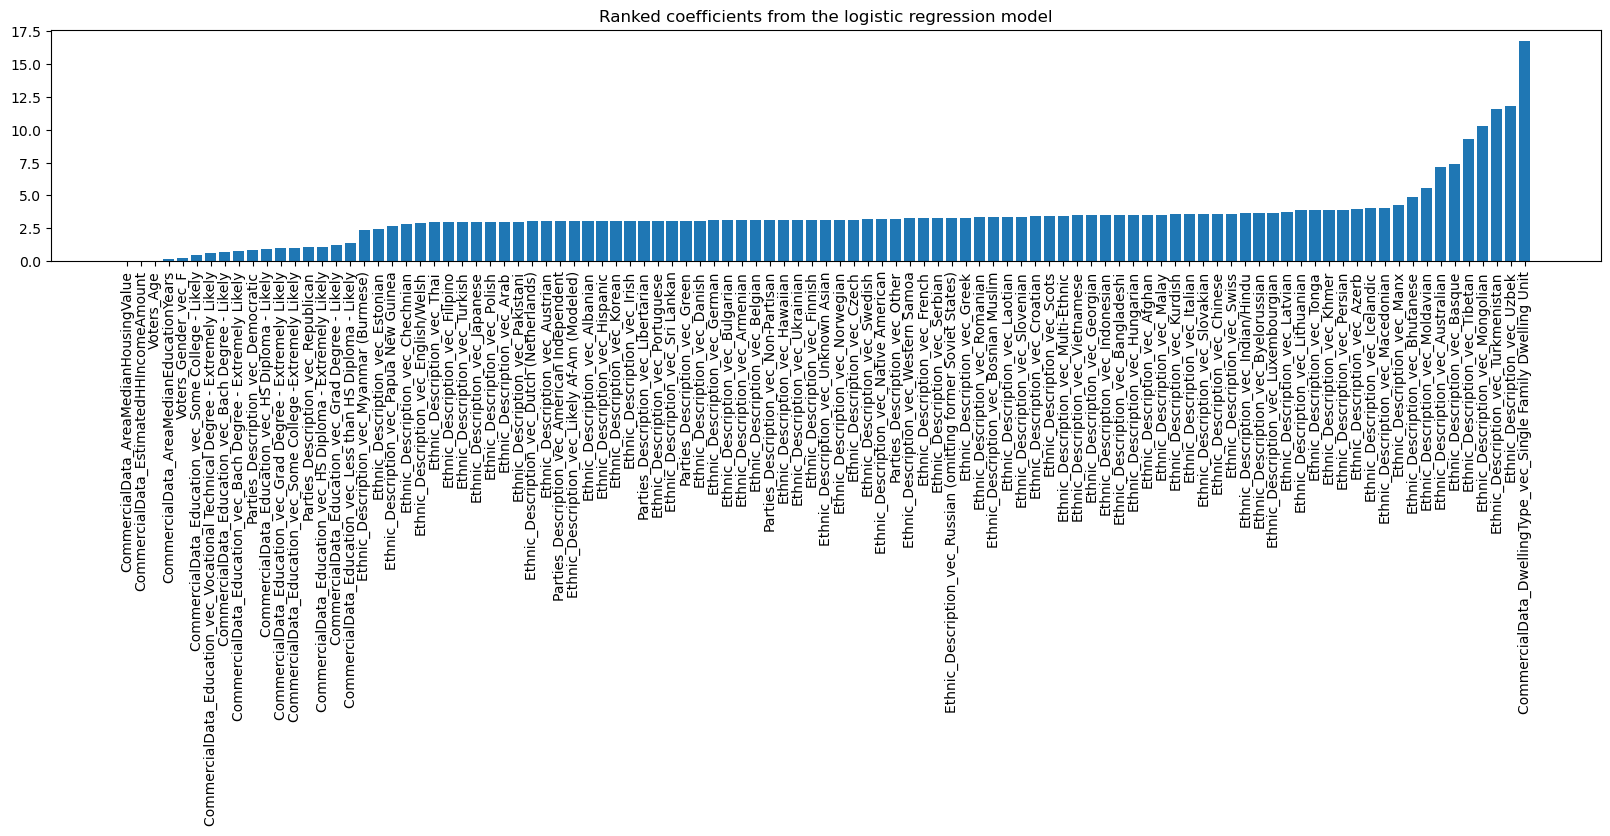

In [36]:
plt.rcParams["figure.figsize"] = (20,3)

plt.xticks(rotation=90)
plt.bar(mi_coefsDF.name, mi_coefsDF.coefs)
plt.title('Ranked coefficients from the logistic regression model')
plt.show()

In [37]:
# Retrieve the logistic regression model from the pipeline
lr_model = az_pipeline_model.stages[-1]

az_coefsArray = np.abs(np.array(lr_model.coefficients))  # coazert to np.array
az_coefsDF = pd.DataFrame(az_coefsArray, columns=['coefs'])  # to pandas

az_coefsDF = az_coefsDF.merge(featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
az_coefsDF.sort_values('coefs', inplace=True)  # Sort them
az_coefsDF.head()

,coefs,name
1,8.585927e-07,CommercialData_AreaMedianHousingValue
3,2.865485e-06,CommercialData_EstimatedHHIncomeAmount
0,2.157681e-02,Voters_Age
4,1.493984e-01,Voters_Gender_vec_F
2,1.630663e-01,CommercialData_AreaMedianEducationYears


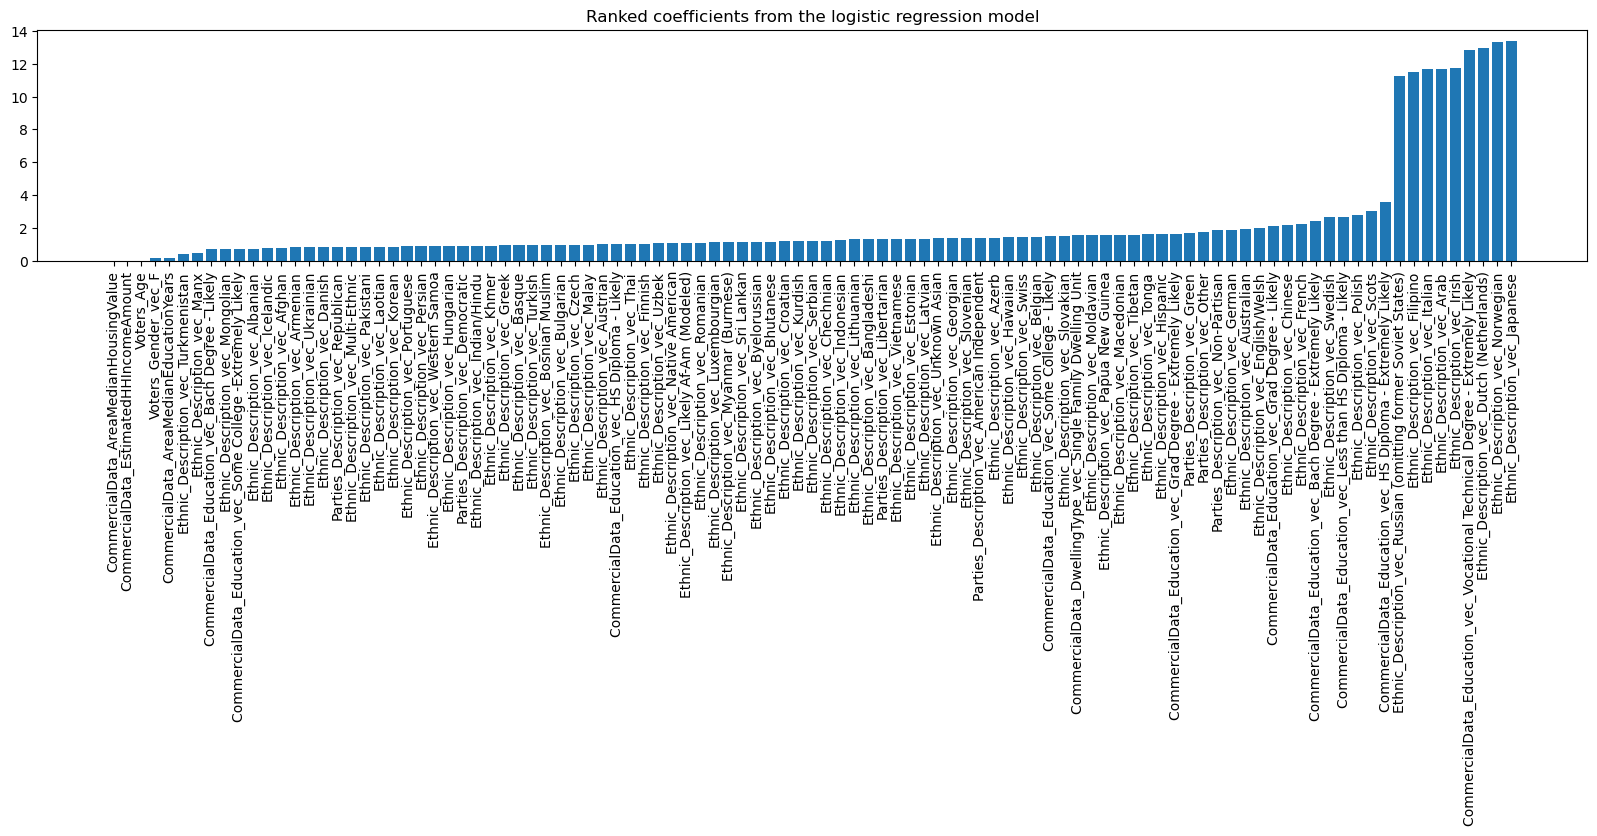

In [38]:
plt.rcParams["figure.figsize"] = (20,3)

plt.xticks(rotation=90)
plt.bar(az_coefsDF.name, az_coefsDF.coefs)
plt.title('Ranked coefficients from the logistic regression model')
plt.show()